In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import sys
sys.path.append('../src')
import monte_carlo as mc
import black_scholes as bs
import binomial_tree as bt
import payoff as po
from scipy.optimize import root_scalar

import pandas as pd
import yfinance as yf
import datetime as dt

# Volatility estimation

Volatility is a key characteristic of an underlying and is heavily used for option pricing.
Outside the Black-Scholes world, volatility is a dynamic quantity and can be estimate in several methods.
Each method comes with its pros and cons.
In this notebook I estimate realized volatilites using three approaches:

- **Yearly blocks**,
- **Sliding window**,
- **The Exponentially Weighted Moving Average (EWMA)**.

For the yearly blocks, we use historic data for the following:

1. SPY — An ETF that tracks the S&P 500 index, widely used as a benchmark for U.S. equities.
2. AAPL — Apple Inc., a leading technology company known for the iPhone, iPad, Mac, and services ecosystem.
3. JPM — JPMorgan Chase & Co., the largest U.S. bank by assets and a global leader in financial services.
4. XOM — Exxon Mobil Corp., one of the world’s largest publicly traded oil and gas companies.


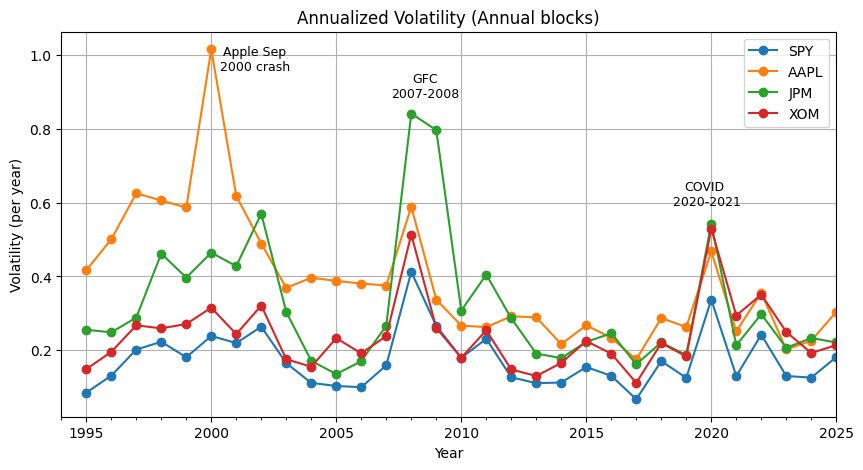

In [3]:
tickers = ["SPY","AAPL","JPM","XOM"]         
start   = "1995-01-01"                
end     = None  

raw = yf.download(tickers, start=start, end=end, interval="1d",auto_adjust=True, progress=False, group_by='ticker')

close = pd.concat({t: raw[t]["Close"] for t in tickers}, axis=1)
close = close.dropna(how="all")
rets = np.log(close).diff().dropna()

annual_vol = rets.groupby(rets.index.year).apply(lambda x: x.std() * np.sqrt(len(x)))
annual_vol.index = pd.to_datetime(annual_vol.index.astype(str))

ax = annual_vol.plot(figsize=(10,5), marker='o', title="Annualized Volatility (Annual blocks)")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax = plt.gca()
ax.text(0.25, 0.9, "Apple Sep\n2000 crash", transform=ax.transAxes,fontsize=9, color="black",ha="center")
ax.text(0.47, 0.83, "GFC\n2007-2008", transform=ax.transAxes,fontsize=9, color="black",ha="center")
ax.text(0.83, 0.55, "COVID\n 2020-2021", transform=ax.transAxes,fontsize=9, color="black",ha="center")
plt.xlim("1994","2025") 
plt.grid(True)
plt.show()

The yearly block estimation provides the coarse-grained picture, in which all the high-frequncy volatility fluctuation are averaged out. 
In the plot we can only observe large trends driven by global events like the global financial crisis of 2007-2008 and COVID which has a wide influnce across industires, seen as a spike in volatility. The "Apple crash" of September 2000 was a historic, one-day 51.9% drop in Apple's stock price on September 29, 2000, seen as a spike in volatility for the corresponding year. We use that time-localized spike in volatility to compare the different methods sliding average methods, which are more sensitivite volatility fluctuations at smaller time scales.

Starting the a vanilla rolling average method, we consider the volatility as a function of time calculated using a past-facing windown of lengths 21,63 and 252 days:

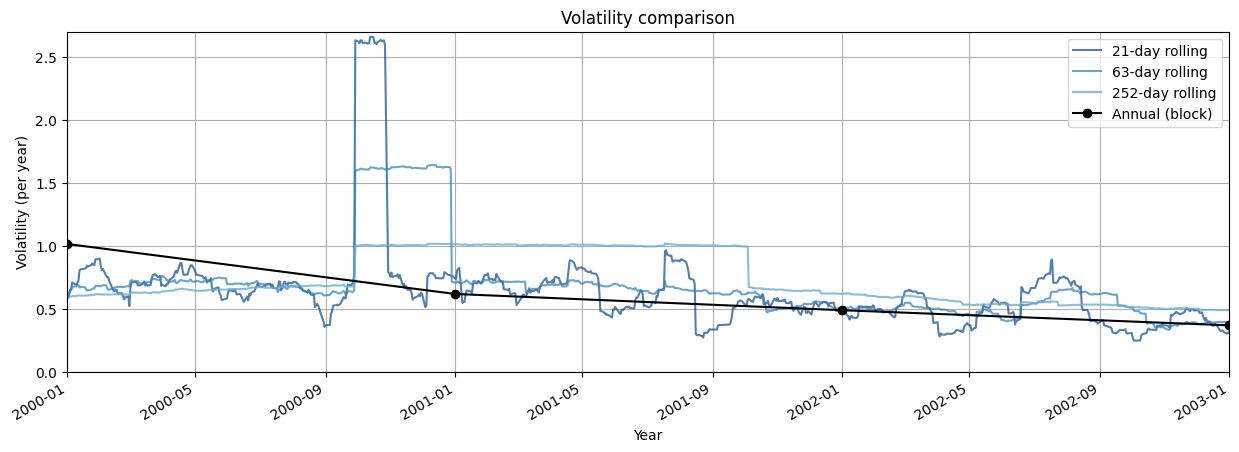

In [9]:
rolling_vol_21d = rets.rolling(window=21).std() * np.sqrt(252)
rolling_vol_63d = rets.rolling(window=63).std() * np.sqrt(252)
rolling_vol_252d = rets.rolling(window=252).std() * np.sqrt(252)

colors = [plt.cm.Blues(0.9),  plt.cm.Blues(0.7),plt.cm.Blues(0.5)]
fig, ax = plt.subplots(figsize=(15,5))


rolling_vol_21d["AAPL"].plot(ax=ax ,alpha=0.7,color=colors[0], label="21-day rolling")

rolling_vol_63d["AAPL"].plot(ax=ax, alpha=0.7, color=colors[1],label="63-day rolling")

rolling_vol_252d["AAPL"].plot(ax=ax, alpha=0.8,color=colors[2], label="252-day rolling")

annual_vol["AAPL"].plot(ax=ax, marker="o", color='black',label="Annual (block)")
plt.ylim(0,2.7) 
plt.xlim("2000","2003") 
ax.set_title("Volatility comparison")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True)
plt.show()

As shown above, the smaller the window size, the more sensitivite the volatility estimate is to high-frequncy features of the realized volatiliy. 

The EWMA method gives more weight to newer input, effectivley smoothening the box-life features of the vanilla moving average estimate.
Below we estimate the realized volatility using EWMA for half-life H=21,63 days, which is related to the commenly used decay factor by $\lambda = 2^{-1/H}$.



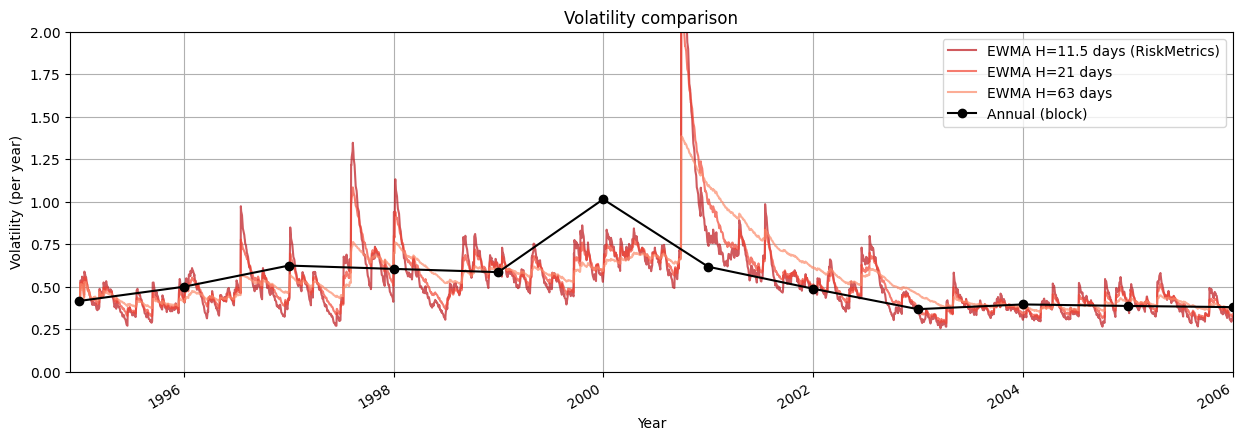

In [11]:

ewm_vol_21 = rets.ewm(halflife=21, adjust=False).std() * np.sqrt(252)
ewm_vol_63 = rets.ewm(halflife=63, adjust=False).std() * np.sqrt(252)
lam = 0.94
alpha = 1 - lam
ewm_vol_094 = rets.ewm(alpha=alpha, adjust=False).std() * np.sqrt(252)

colors = [plt.cm.Blues(0.8),  plt.cm.Blues(0.6),plt.cm.Blues(0.4)]
colors2 = [plt.cm.Reds(0.8),  plt.cm.Reds(0.6),plt.cm.Reds(0.4)]
fig, ax = plt.subplots(figsize=(15,5))


ewm_vol_094["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[0], label="EWMA H=11.5 days (RiskMetrics)")
ewm_vol_21["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[1], label="EWMA H=21 days")
ewm_vol_63["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[2], label="EWMA H=63 days")


annual_vol["AAPL"].plot(ax=ax, marker="o", color='black',label="Annual (block)")
plt.ylim(0,2) 
plt.xlim("12-1994","2006") 
ax.set_title("Volatility comparison")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True)
plt.show()

Finally, puting all of the estimates together:

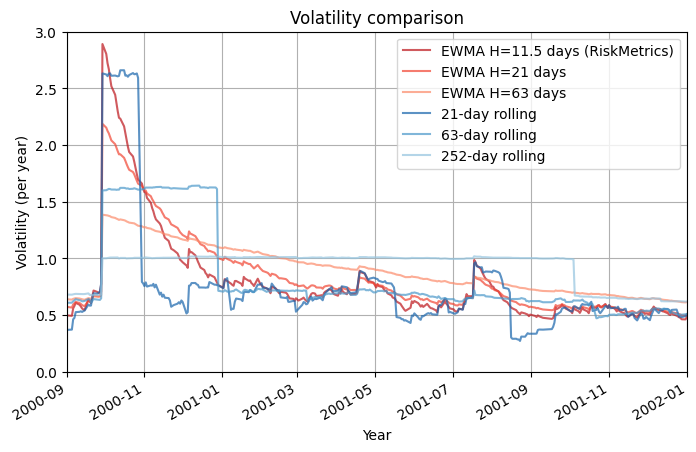

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
ewm_vol_094["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[0], label="EWMA H=11.5 days (RiskMetrics)")

ewm_vol_21["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[1], label="EWMA H=21 days")

ewm_vol_63["AAPL"].plot(ax=ax ,alpha=0.7,color=colors2[2], label="EWMA H=63 days")

rolling_vol_21d["AAPL"].plot(ax=ax ,alpha=0.7,color=colors[0], label="21-day rolling")

rolling_vol_63d["AAPL"].plot(ax=ax, alpha=0.7, color=colors[1],label="63-day rolling")

rolling_vol_252d["AAPL"].plot(ax=ax, alpha=0.7,color=colors[2], label="252-day rolling")


# annual_vol["AAPL"].plot(ax=ax, marker="o", alpha=0.2,color='black',label="Annual (block)")
plt.ylim(0,3) 
plt.xlim("09-2000","2002") 
ax.set_title("Volatility comparison")
ax.set_ylabel("Volatility (per year)")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True)
plt.show()

As a last exercise, we estimate the implied volatility of AMZN stock and compare to the implied volatility estimate of yfinance.

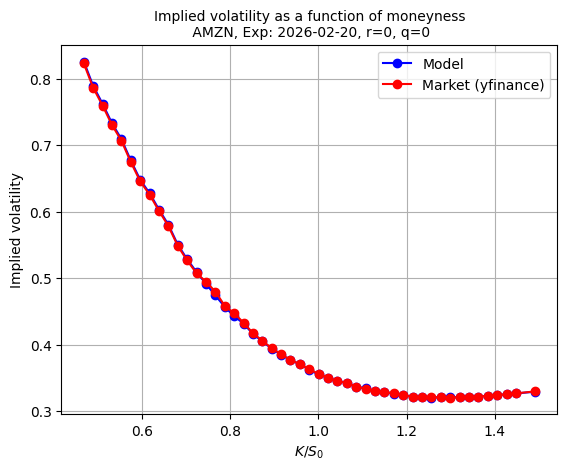

In [12]:
ticker = yf.Ticker("AMZN")
chain = ticker.option_chain(ticker.options[10])  # farthest expiry
calls = chain.calls


S = ticker.history(period="1d")["Close"].iloc[-1]   
K = np.array(calls.iloc[:,2])                              
expiry = pd.to_datetime(ticker.options[10])        
today = pd.Timestamp.today().normalize()
T = (expiry - today).days / 365                    
r = 0.00                                         
price = (calls.iloc[:,4]+calls.iloc[:,5])/2;
# price = calls.iloc[:,3]
impV = np.array(calls.iloc[:,10])       
res= []
for i in range(0,len(K)):
    res.append(bs.implied_vol(S, K[i] ,r, 0, T, 'call',price[i]))
res = np.array(res)

plt.plot(K/S, res, marker='o',color='blue',label='Model')
plt.plot(K/S, impV, marker='o',color='red',label='Market (yfinance)')
plt.xlabel(r'$K/S_0 $')
plt.ylabel('Implied volatility')
plt.title("Implied volatility as a function of moneyness\n AMZN, Exp: " +ticker.options[10]  + ", r=0, q=0",fontsize = '10')
plt.legend()
plt.grid(True)

We find a good agreement between our calcaultion and the provided IV estimates, as shown below where we plot $\left| 1-v_{\text{model}}/v_{\text{market}}\right|$.

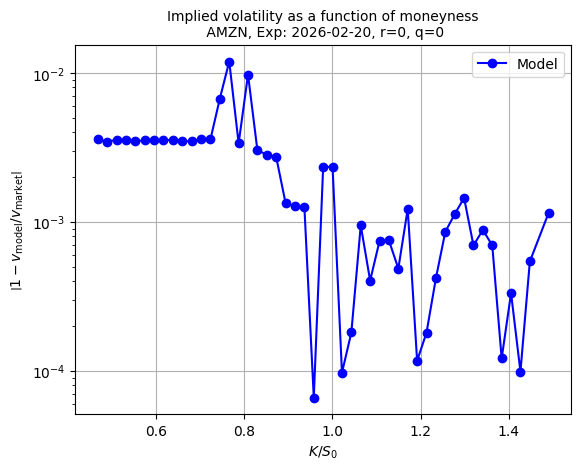

In [23]:
plt.plot(K/S, abs(1-res/impV), marker='o',color='blue',label='Model')
plt.yscale('log')   # log scale on y-axis
plt.xlabel(r'$K/S_0 $')
plt.ylabel(r'$\left| 1-v_{\text{model}}/v_{\text{market}}\right|$')
plt.title("Implied volatility as a function of moneyness\n AMZN, Exp: " +ticker.options[10]  + ", r=0, q=0",fontsize = '10')
plt.legend()
plt.grid(True)